In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Libraries**

In [ ]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import models

from PIL import Image
from collections import Counter
from tqdm import tqdm

import imgaug.augmenters as iaa
import albumentations as A

In [ ]:
# Check if a GPU is available and use it, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

# **Data Augmenting**

In [ ]:
# Define the paths
original_images_folder = "/content/drive/MyDrive/WineData/images/"
original_labels_file = "/content/drive/MyDrive/WineData/labels/wine_producer_label/wine_labels_yolo_format_producer.csv"
output_images_folder = "/content/drive/MyDrive/WineData/augmented_images/"
output_labels_file = "/content/drive/MyDrive/WineData/labels/wine_producer_label/augmented_wine_labels_yolo_format_label.csv"
min_augmentations_per_label = 20  # Minimum number of augmentations per label
max_augmentations_per_label = 25  # Maximum number of augmentations per label

# Load the original labels
labels_df = pd.read_csv(original_labels_file)

# Create output folders if they don't exist
os.makedirs(output_images_folder, exist_ok=True)

# Create an empty DataFrame to store augmented labels
augmented_labels_df = pd.DataFrame(
    columns=[
        "label_id", "yolo_x", "yolo_y", "yolo_width", "yolo_height", "label_name", "image_name"
    ]
)

# Define the augmentation sequence
augmentation_seq = iaa.Sequential([
    iaa.Flipud(0.5),
    iaa.Affine(rotate=(-10, 10)),
    iaa.GaussianBlur(sigma=(0, 1.0)),
    iaa.LinearContrast((0.8, 1.2)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),
    iaa.Sharpen(alpha=(0, 0.5), lightness=(0.8, 1.2))
])

# Augment the images and labels
for index, row in labels_df.iterrows():
    image_path = os.path.join(original_images_folder, row["image_name"])
    label = row["label_id"]
    num_augmentations = np.random.randint(
        min_augmentations_per_label, max_augmentations_per_label + 1
    )  # Randomly select the number of augmentations

    # Load the image
    image = np.array(Image.open(image_path))

    # Apply augmentations
    for i in range(num_augmentations):
        # Apply augmentation to the image
        augmented_image = augmentation_seq.augment_image(image)

        # Convert the augmented image back to PIL format
        augmented_image = Image.fromarray(augmented_image.astype(np.uint8))

        # Save the augmented image
        output_image_path = os.path.join(
            output_images_folder, f"augmented_{index}_{i}.jpg"
        )
        augmented_image.save(output_image_path)

        # Create a new row for the augmented label
        augmented_row = pd.Series({
            "label_id": label,
            "yolo_x": row["yolo_x"],
            "yolo_y": row["yolo_y"],
            "yolo_width": row["yolo_width"],
            "yolo_height": row["yolo_height"],
            "label_name": row["label_name"],
            "image_name": f"augmented_{index}_{i}.jpg"
        })

        # Append the augmented label to the DataFrame
        augmented_labels_df = augmented_labels_df.append(augmented_row, ignore_index=True)

# Save the augmented labels to a single file
augmented_labels_df.to_csv(
    output_labels_file,
    index=False,
    columns=[
        "label_id", "yolo_x", "yolo_y", "yolo_width", "yolo_height", "label_name", "image_name"
    ]
)

In [ ]:
len(os.listdir('/content/drive/MyDrive/WineData/augmented_images/'))

# **Data Preprocessing**

In [ ]:
class WineDataset(Dataset):
    def __init__(self, data_path, labels_file, transform=None):
        self.data_path = data_path
        self.labels_df = pd.read_csv(labels_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, index):
        image_path = os.path.join(self.data_path, self.labels_df.iloc[index]['image_name'])
        image = Image.open(image_path).convert('RGB')
        label = self.labels_df.iloc[index]['producer_id'] - 1  # Subtract 1 to encode labels

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Define the paths
data_path = "/content/drive/MyDrive/WineData/augmented_images"
labels_file = "/content/drive/MyDrive/WineData/labels/wine_producer_label/augmented_wine_labels_yolo_format_producer.csv"
output_folder = "/content/drive/MyDrive/WineData/preprocessed"

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Define transformations for resizing and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize the image to 224x224
    transforms.ToTensor(),             # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
])

# Create WineDataset instance
dataset = WineDataset(data_path, labels_file, transform=transform)

# Perform train-test split (80%/10%/10%)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Save preprocessed data loaders
torch.save(train_loader, os.path.join(output_folder, "train_loader.pth"))
torch.save(val_loader, os.path.join(output_folder, "val_loader.pth"))
torch.save(test_loader, os.path.join(output_folder, "test_loader.pth"))

# **Check train-valid-test classes distribution**

In [ ]:
# Calculate class distribution in train loader
train_class_distribution = {}
for _, labels in train_loader:
    for label in labels:
        if label.item() not in train_class_distribution:
            train_class_distribution[label.item()] = 0
        train_class_distribution[label.item()] += 1

# Calculate class distribution in validation loader
val_class_distribution = {}
for _, labels in val_loader:
    for label in labels:
        if label.item() not in val_class_distribution:
            val_class_distribution[label.item()] = 0
        val_class_distribution[label.item()] += 1

# Calculate class distribution in test loader
test_class_distribution = {}
for _, labels in test_loader:
    for label in labels:
        if label.item() not in test_class_distribution:
            test_class_distribution[label.item()] = 0
        test_class_distribution[label.item()] += 1

# Print class distribution in train loader
print("Train Loader - Class Distribution:")
for label_id, count in train_class_distribution.items():
    print(f"Class {label_id + 1}: {count} samples")

# Print class distribution in validation loader
print("Validation Loader - Class Distribution:")
for label_id, count in val_class_distribution.items():
    print(f"Class {label_id + 1}: {count} samples")

# Print class distribution in test loader
print("Test Loader - Class Distribution:")
for label_id, count in test_class_distribution.items():
    print(f"Class {label_id + 1}: {count} samples")


# **Model Design And Training**

In [ ]:
model_path = "/content/drive/MyDrive/WineData/model_weight_save/producer_model_weight/model_resnet50_weight_{}.pth"
model_path

In [ ]:
"""
Epoch 1 - Training: 100%|██████████| 406/406 [2:15:55<00:00, 20.09s/it]
Epoch 1 - Validation: 100%|██████████| 51/51 [05:13<00:00,  6.14s/it]
Epoch 1 - Train Loss: 3.7395 - Train Acc: 14.40% - Val Loss: 2.9221 - Val Acc: 32.94%
Epoch 2 - Training: 100%|██████████| 406/406 [4:59:12<00:00, 44.22s/it]
Epoch 2 - Validation: 100%|██████████| 51/51 [24:10<00:00, 28.44s/it]
Epoch 2 - Train Loss: 1.7837 - Train Acc: 63.77% - Val Loss: 0.7298 - Val Acc: 88.65%
Epoch 3 - Training: 100%|██████████| 406/406 [2:14:30<00:00, 19.88s/it]
Epoch 3 - Validation: 100%|██████████| 51/51 [05:04<00:00,  5.97s/it]
Epoch 3 - Train Loss: 0.3982 - Train Acc: 95.30% - Val Loss: 0.1212 - Val Acc: 99.20%
Epoch 4 - Training: 100%|██████████| 406/406 [2:30:02<00:00, 22.17s/it]
Epoch 4 - Validation: 100%|██████████| 51/51 [05:02<00:00,  5.94s/it]
Epoch 4 - Train Loss: 0.1004 - Train Acc: 99.44% - Val Loss: 0.0390 - Val Acc: 99.94%
"""

In [ ]:
# Load the preprocessed data loaders
train_loader = torch.load("/content/drive/MyDrive/WineData/preprocessed/train_loader.pth")
val_loader = torch.load("/content/drive/MyDrive/WineData/preprocessed/val_loader.pth")
test_loader = torch.load("/content/drive/MyDrive/WineData/preprocessed/test_loader.pth")

# Load the ResNet-50 model
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 75)
model = model.to(device)

# Load the model checkpoint
checkpoint_path = "/content/drive/MyDrive/WineData/model_weight_save/producer_model_weight/model_resnet50_weight_3.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 10

for epoch in range(4, num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100.0 * correct / total

    # Validation
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100.0 * correct / total

    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_accuracy:.2f}%")

    # Save the trained model
    torch.save(model.state_dict(), model_path.format(epoch))


In [ ]:
torch.save(model.state_dict(), model_path.format(5))

# **Evaluating The Model**

In [1]:
# Load the preprocessed data loaders
train_loader = torch.load("/content/drive/MyDrive/WineData/preprocessed/train_loader.pth")
val_loader = torch.load("/content/drive/MyDrive/WineData/preprocessed/val_loader.pth")
test_loader = torch.load("/content/drive/MyDrive/WineData/preprocessed/test_loader.pth")

# Load the ResNet-50 model
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 75)
model = model.to(device)

# Load the model checkpoint
checkpoint_path = "/content/drive/MyDrive/WineData/model_weight_save/producer_model_weight/model_resnet50_weight_5.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Testing
model.eval()
running_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = running_loss / len(test_loader)
test_accuracy = 100.0 * correct / total

print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_accuracy:.2f}%")

Test Loss: 0.3982 - Test Acc: 95.30%


# **Precision & Recall**

In [2]:
from sklearn.metrics import precision_score, recall_score
import torch

# Load the model checkpoint
checkpoint_path = "/content/drive/MyDrive/WineData/model_weight_save/producer_model_weight/model_resnet50_weight_final.pth"
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 75)
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)
model.eval()

predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 90.7%
Recall: 89.3%


# **Save the trained model's weights**

In [ ]:
# Save the trained model
torch.save(model.state_dict(), model_path.format("final"))

In [ ]:
import pandas as pd
import os

# **Predict wine producer given an image from the intenet**

In [ ]:
label_id = pd.read_csv('/content/drive/MyDrive/WineData/labels/label_id.csv')
label_id = label_id['label_name'].values.tolist()
label_id[11]

'bottega'

0.5973966121673584


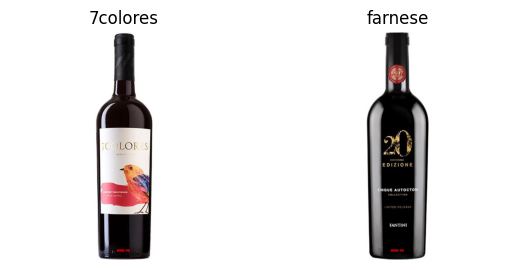

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from PIL import Image
from torchvision.transforms import ToTensor, Normalize, Resize
import urllib
from time import time

# Load the model checkpoint
checkpoint_path = "/content/drive/MyDrive/WineData/model_weight_save/producer_model_weight/model_resnet50_weight_final.pth"
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 75)
model.load_state_dict(torch.load(checkpoint_path))
device = torch.device('cpu')
model = model.to(device)
model.eval()

# Preprocess the image from the internet
times = []
folder_path = '/content/drive/MyDrive/WineData/demo'

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 7))
import math
list_filenames = os.listdir(folder_path)
rows = int(math.sqrt(len(list_filenames)))
columns = (len(list_filenames) // rows) + 1
for index, filename in enumerate(list_filenames):
  time_1 = time()
  image_path = os.path.join(folder_path, filename)
  image = Image.open(image_path)
  preprocess = transforms.Compose([
      Resize((224, 224)),
      ToTensor(),
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  input_image = preprocess(image)
  input_image = input_image.unsqueeze(0)  # Add an extra dimension for batch size

  # Make the prediction using the preprocessed image
  with torch.no_grad():
      output = model(input_image)

  # Get the predicted class index
  predicted_class = torch.argmax(output).item()
  fig.add_subplot(rows, columns, index + 1)

  # showing image
  plt.imshow(image)
  plt.axis('off')
  plt.title(label_id[predicted_class])
  times.append(time() - time_1)
print(sum(times)/len(times))

In [ ]:
#print("The Wine's Producer is: {}".format(label_id[predicted_class]))